In [ ]:
## Accessing and Using the UN General Debate Corpus (UNGDC):
## A Simple Demonstration using a Jupyter Notebook, Pandas, and SpaCy

# By Nicolas de Zamaroczy

# The purpose of this Python script is to access the UN General Debate Corpus (UNGDC) dataset and then use tools in the SpaCy package to perform simple quantitative text analysis of the corpus.

# The UNGDC dataset was compiled by Slava Jankin Mikhaylov, Alexander Baturo & Niheer Dasandi.
# You can find all of their replication materials on this webpage: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0TJX8Y
# The 2017 scholarly article they published in the journal Research & Politics which draws upon the dataset can be found here [pay-walled]: https://journals.sagepub.com/doi/full/10.1177/2053168017712821
# Another recent scholarly article using this dataset can be found here: https://link.springer.com/article/10.1007/s11558-020-09404-y

# Many thanks to Leo K. for some invaluable troubleshooting assistance!

# Version 3.7
# Version Changelog:
# - Added cell calculating percentage of countries focused on climate change in 2009
# - Succesfully implemented Russian linguistic similarity analysis

In [1]:
## Load necessary packages

# Core Packages
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
import en_core_web_lg # Loads the largest version of SpaCy's core English-language library (which has built in words vectors we will use to perform similarity analyses)

# Other Key Packages
import numpy as np # Used to structure data
import pandas as pd # Used to structure data
import seaborn as sns # Used to visualize data
import matplotlib.pyplot as plt # Used to visualize data
%matplotlib inline

# Additional Packages
import os # Used in a few cells to set and walk directories
import re # Used in one cell to write regular expressions
import humanize # Used in one cell to render large numbers in easily interpretable terms
from tqdm import tqdm # Used in several cells to create a progress bar
from tqdm.gui import tqdm as tqdm_gui # Used in several cells to create a progress bar
from pathlib import Path # Used in one cell to write a file to a given directory

In [2]:
## Create a progress bar for long steps

# Some of the below cells can take quite a while to run.
# Accordingly, we use the tqdm package to create a progress bar to help track how long the operation will take
tqdm.pandas(desc='Progress')

C:\Users\nicol\AppData\Roaming\Python\Python37\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
## Load the files into a dataframe

# Go to https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0TJX8Y

# Unzip the file named 'UNGDC 1970-2018.zip' to a directory of your choice on your hard drive.
# [This may take a few minutes.]

# In the directory you have chosen, you now have 8,093 speeches in plain text format (with UTF-8 encoding).
# Each speech is named using the following convention: ISO 3166-1 alpha-3 country code, followed by the UN Session number, followed by year.
# E.g. USA_73_2018.txt is the full text of the speech the United States' representative gave during the UN's 73rd General Debate session in 2018.

# To begin, set your working directory to where you saved the zip file
directory = "C:\\Users\\nicol\\Desktop\\Data Science Stuff\\UNGDC\\Text Files"

os.chdir(directory) # Changes the directory

# Confirm that working directory is correctly set
print(os.getcwd())

C:\Users\nicol\Desktop\Data Science Stuff\UNGDC\Text Files


In [4]:
# Create a list of all the file names in the working directory
filenames = os.listdir(path=directory)

# Print the first ten file names as a check
print(filenames[:10])

['AFG_26_1971.txt', 'AFG_27_1972.txt', 'AFG_28_1973.txt', 'AFG_29_1974.txt', 'AFG_30_1975.txt', 'AFG_31_1976.txt', 'AFG_32_1977.txt', 'AFG_33_1978.txt', 'AFG_34_1979.txt', 'AFG_35_1980.txt']


In [14]:
# Create the dataframe
# Note: Reading all 8000+ files may take a while

row_list = [] # Create an empty list which we'll eventually cast as a DataFrame

for folder, subfolders, filenames in os.walk(directory): # Use the os.walk module to walk our directory
    for file in filenames: 
        info = {'country_code':file[0:3]}              # Create a series called info which reads the country code from the file name
        info['year'] = file[-8:-4]                        # Add a column called year to info, based on the filename
        with open(directory+'/'+file,encoding='utf-8') as f:   # Open each file in the directory
            info['raw_text'] = f.read()  # Read the contents of the file into a new column of info called text
        row_list.append(info)       # Append all of info to the empty placeholder list
df = pd.DataFrame(row_list)       # Turns our list into a DataFrame named df

# Print the shape of the dataframe as a check
df.shape

(8093, 3)

In [6]:
# Inspect the current dataframe structure
random_subset = df.sample(n=10,replace=False,random_state=101, axis='index') # We choose a random subset of 10 entries in the dataframe to inspect
random_subset

,country_code,year,raw_text
7480,UGA,1992,"Mr. President, allow me to congratulate \nyou ..."
1621,COL,2013,I \nshould like to depart slightly from protoc...
375,AUT,1975,81.\tTogether with all the other Members of th...
3070,GTM,2012,"﻿At the\noutset, allow me to greet Mr. Vuk Jer..."
7551,UKR,2014,"Ukraine, as a co-founder \nof the United Natio..."
7178,TJK,1998,"First allow me to congratulate you, Sir, on yo..."
2228,EGY,1979,"﻿It gives me great pleasure at the outset, Mr...."
4668,MDG,1992,The General \nAssembly's choice of Mr. Ganev t...
7906,YEM,1971,154.\tIt is with great pleasure that I extend ...
3858,KEN,1974,"Mr. President, allow me first to join the prev..."


In [15]:
# Adding Country Names

# Some of the country codes may not be immediately recognizeable to readers.
# Accordingly, we want to add a column with the English-language short version of the country's name.
# We have this information stored in a different CSV file

df_country_names = pd.read_csv('C:\\Users\\nicol\\Desktop\\Data Science Stuff\\UNGDC\\Country Names.csv')
df_country_names.head(10)

,country_code,country_name
0,AFG,Afghanistan
1,AGO,Angola
2,ALB,Albania
3,AND,Andorra
4,ARE,United Arab Emirates
5,ARG,Argentina
6,ARM,Armenia
7,ATG,Antigua and Barbuda
8,AUS,Australia
9,AUT,Austria


In [16]:
# Merge the two dataframes
df = df.merge(df_country_names,how='left')
df = df[['country_code','country_name','year','raw_text']] # Renames the columns
df

,country_code,country_name,year,raw_text
0,AFG,Afghanistan,1971,"82.\tMr. President, at the outset, I wish to c..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat..."
2,AFG,Afghanistan,1973,﻿1.\tIt is a great pleasure for me to congratu...
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ..."
4,AFG,Afghanistan,1975,"114.\t Mr. President, it is a pleasure for the..."
...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate \nMr. Kutesa on assum...
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...


In [17]:
## Text Pre-processing

# As we can see, the raw text strings are full of new paragraph and new line markers.
# As part of our pre-processing, we strip them out.

df['proc_text'] = df['raw_text'].progress_apply(lambda x: x.replace('\n',' '))
df['proc_text'] = df['proc_text'].progress_apply(lambda x: x.replace('\r',' '))
df['proc_text'] = df['proc_text'].progress_apply(lambda x: x.replace('\t',' '))

# There are also both paragraph numbers and page numbers scattered throughout the speeches, leftover as artifacts from the text creation process.
# They have minimal semantic value, so we remove them use a regular expression.
# Note, however, that doing so probably involves some information loss (for instance, if a number ends a sentence), but it's worth the cost.
df['proc_text'] = df['proc_text'].apply(lambda x: re.sub(r'\d+\.','',x)) # Removes any set of digits immediately followed by a period
df

Progress: 100%|█████████████████████████████████████████████████████████████████| 8093/8093 [00:00<00:00, 95646.61it/s]


,country_code,country_name,year,raw_text,proc_text
0,AFG,Afghanistan,1971,"82.\tMr. President, at the outset, I wish to c...","Mr. President, at the outset, I wish to congr..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","Mr. President, on behalf of the Afghan delegat..."
2,AFG,Afghanistan,1973,﻿1.\tIt is a great pleasure for me to congratu...,﻿ It is a great pleasure for me to congratulat...
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","Mr. President, permit me to convey to you the ..."
4,AFG,Afghanistan,1975,"114.\t Mr. President, it is a pleasure for the...","Mr. President, it is a pleasure for the dele..."
...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate \nMr. Kutesa on assum...,Allow me to congratulate Mr. Kutesa on assumi...
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,Allow me at the outset to extend to Mr. Mogens...
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","Let me begin my congratulating you, Sir, on yo..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,I wish to congratulate Mr. Miroslav Lajčák on ...


In [11]:
# On the whole, our processed text looks significantly better (and is much better suited for SpaCy, which works best with actual natural speech).

# We can view the text of any given speech (selected by country code and year) with this technique:
print(df[(df['country_code']=='NAM') & (df['year']=='1990')]['proc_text'].to_list()[0]) # Change the strings for the year and country code to whatever you want

﻿it gives me great pleasure to address the forty-fifth session of the General Assembly. At the outset, let me extend my heartfelt congratulations to you, Mr. President, on your unanimous election and wish you well in the heavy responsibilities entrusted to you. Your vast experience and diplomatic skill assure us that the work of the Assembly is in good hands. I should like to express my personal happiness and sense of pride to your predecessor, General Joseph Garba, for the efficiency and wisdom with which he steered the forty-fourth session to a successful conclusion. We truly deserves praise by Africa and the world at large for a job well done. The United Nations family was recently reinforced by a new Member, the Principality of Liechtenstein, whose membership my Government warmly welcomes. If I may say so, I had been looking forward to addressing the Assembly as President of the newest Member State of the United Nations. However, the Principality of Liechtenstein overtook us before

In [18]:
# Now that we've gotten our processed texts, let's drop the raw_text column to save space in our dataframe
df = df.drop(columns=['raw_text'])
df.head()

,country_code,country_name,year,proc_text
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat..."
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ..."
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele..."


In [19]:
## Creating SpaCy Doc Objects

# The core of the SpaCy package is the doc object, which takes a string of text and calculates the relationship between all the individual words within it at the sentence level.
# (For documentation on doc objects, see https://spacy.io/api/doc)

# Creating a doc object for our speeches is computationally intensive, as each contains thousands of words.
# In addition, we have 8000+ speeches to get through, which can take quite a while to process.

# We begin by instantiating SpaCy's largest English-language library as a pipeline named 'nlp'
nlp = en_core_web_lg.load()
nlp.remove_pipe('parser') # We disable the parser segment in the pipeline, which is computationally intensive and which we won't need for the below analysis:
print(nlp.pipe_names)

['tagger', 'ner']


In [20]:
# That leaves us with two elements in the pipeline:
# - the tagger, which uses white space and punctuation to figure out what the individual words in the string are and lemmatize them;
# - the named entity recognizer, which uses syntactic patterns to match tokens against a pre-existing list of known terms.

# We are now ready to actually create the doc objects.
# !! This step can take a very long time (approx. 30 minutes on my machine)!!

df['doc_obj'] = df['proc_text'].progress_apply(lambda x: nlp(x))
# Uses a lambda expression to create a SpaCy Doc Object from each pre-processed string, which are stored in a new column called doc_obj
df

Progress: 100%|████████████████████████████████████████████████████████████████████| 8093/8093 [30:03<00:00,  4.49it/s]


,country_code,country_name,year,proc_text,doc_obj
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha..."
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c..."
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to..."
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f..."
...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ..."
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M..."
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj..."


In [21]:
# Verify that the 'doc_obj' column does indeed contain SpaCy doc objects
type(df['doc_obj'][0])

spacy.tokens.doc.Doc

In [22]:
# You can access the doc object of any given speech by specifying a country code and a year:
df[(df['country_code']=='LTU') & (df['year']=='2011')]['doc_obj'].to_list()[0]
# This looks like a string, but if you check its type you'll see that it's actually a SpaCy doc_obj.

# Important Note!  This method is how we will normally access doc_objects throughout this script.
# We specify two conditions (country code and year) that limit our dataframe to a single line and then call the doc_obj column.
# However type(df[(df['country_code']=='LTU') & (df['year']=='2013')]['doc_obj']) is considered to be a Pandas series, even though it only contains 1 element.
# Therefore to gain access to the actual doc_obj, we cast it to a list and then grab the first (and only) item in that list.

Twenty years ago,  Lithuania rejoined the international community of  sovereign States and became a Member of the United  Nations. The unique experience of peaceful transition,  State-building and reforms during the past 20 years has  made Lithuania stronger and more determined. History  has taught us that an honest broker at the national,       11-50871 16    bilateral or multilateral level is the key to solving  almost any problem.    In recent years, we have invested in building our  capacity to become such a broker. Lithuania has just  concluded its chairmanship of the Community of  Democracies. Today, we are proud to chair the  Organization for Security and Cooperation in Europe. I  am also confident that Lithuania’s commitment to  effective multilateralism and the fostering of dialogue  and cooperation internationally makes it a deserving  candidate for non-permanent membership of the  Security Council. We are ready and determined to run  for a non-permanent seat in the Security 

In [23]:
## Describing the Corpus

# Number of years
print('Number of years in the corpus: '+str(len(df['year'].unique())))

# Number of countries
print('Number of unique countries in the corpus: '+str(len(df['country_code'].unique())))

# Number of documents
num_docs = len(df['proc_text'])
print(f'Number of documents in the corpus: {num_docs}')

# Total number of words
num_words = 0
for string in df['proc_text']:
    word_list = string.split() # This is a very rough and crude way of approximating words, by simply using white space to create different items in a list.  Still, it shouldn't be too far off, and we can't use something like len(doc_obj) because it counts punctuation as tokens
    num_words = num_words + len(word_list)
print('Number of words in the corpus: approx. '+str(humanize.intword(num_words)))

# Average number of words per document
avg_length = num_words / num_docs
print('Average number of words per document: '+str(humanize.intword(avg_length)))

# Number of unique tokens
seen = set()
for doc in df['doc_obj']:
    for token in doc:
        seen.add(token.text)
num_tokens = len(seen)
print('Number of unique tokens in the corpus: '+str(humanize.intword(num_tokens)))

Number of years in the corpus: 49
Number of unique countries in the corpus: 200
Number of documents in the corpus: 8093
Number of words in the corpus: approx. 22.6 million
Average number of words per document: 2794
Number of unique tokens in the corpus: 73915


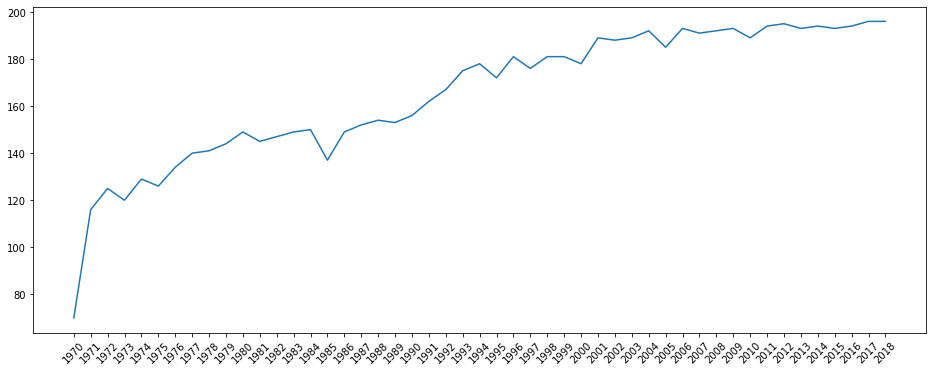

In [24]:
# The number of countries present at the UNGD has increased over time (due to new countries joining the UN)

number_speeches = df.groupby(['year'])['country_name'].apply(lambda x: len(x))

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.ylabel=('Number of Countries') # Line not working for some reason
plt.xlabel=('Year') # Line not working for some reason
plt.plot(number_speeches)

In [25]:
## Application 1: Tracking the Importance of Topics over Time
# Tracking Mentions of Nuclear Weapons in the UNGD

# The imminent entry into force of the Treaty on the Prohibition of Nuclear Weapons on January 22, 2021
# (following its ratification by 50 countries) seems like a good impetus to see how nuclear weapons are discussed in UN General Debates.

# We can use SpaCy's Matcher method to check each document for specific phrases.
# Note: Choices you make with regard to phrase matching affect your substantive results. See Appendix 1 for a demonstration.
# SpaCy has both a Matcher method, matches based on patterns (for instance, regular expressions), as well as a PhraseMatcher method but SpaCy also has a PhraseMatcher method, which works well for multi-token phrases.
# After testing, we are going to use the PhraseMatcher method.

matcher = PhraseMatcher(nlp.vocab, attr="LOWER") # 'Lower' ensures that all our searching is case-insensitive
nuke_terms = ['nuclear weapon', 'nuclear weapons', 'nuclear armament', 'nuclear armaments', 'nuclear arsenal',
            'atomic weapon', 'atomic weapons', 'atomic armament', 'atomic armaments', 'atomic arsenal',
            'strategic weapon', 'strategic weapons', 'strategic armament', 'strategic armaments', 'strategic arsenal']
patterns = [nlp.make_doc(text) for text in nuke_terms]
matcher.add('nuke_terms', None, *patterns)

df['nuke_mentions'] = df['doc_obj'].progress_apply(lambda x: len(matcher(x)))
df

Progress: 100%|█████████████████████████████████████████████████████████████████| 8093/8093 [00:00<00:00, 13809.41it/s]


,country_code,country_name,year,proc_text,doc_obj,nuke_mentions
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ...",0
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha...",0
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c...",0
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to...",1
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f...",4
...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...",0
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...",0
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...",0
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...",0


[Text(0, 0.5, 'Total Mentions of Nuclear Weapons'), Text(0.5, 0, 'Year')]

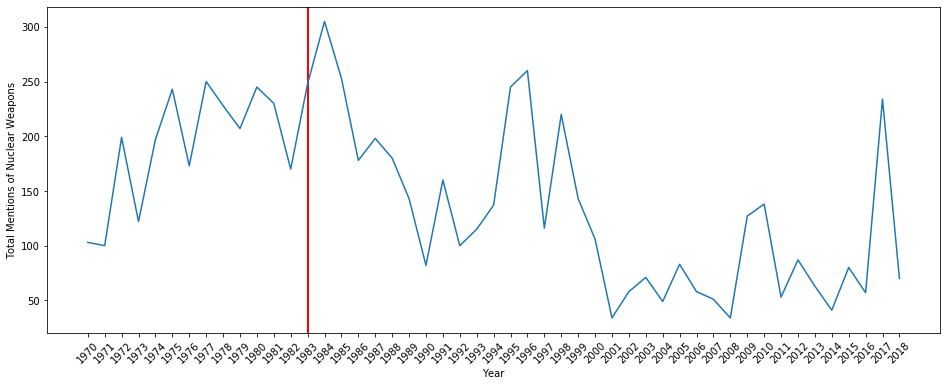

In [26]:
# Visualizing Mentions of Nuclear Weapons over Time

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(13,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig1 = sns.lineplot(data=df, x='year', y='nuke_mentions', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig1.set(xlabel='Year', ylabel='Total Mentions of Nuclear Weapons') # Why does this line randomly print a bunch of output text?

In [27]:
# The above chart is suggestive.
# The greatest number of mentions is during the early 1980s, a period which many historians view as a 'New Cold War' following the detente of the 1970s (see: https://en.wikipedia.org/wiki/Cold_War#New_Cold_War_(1979%E2%80%931985)).
# Indeed, 1983 (marked by a red line above) was arguably the year the planet came closest to full-blown nuclear war: see (**shameless plug warning**): https://nicolasdezamaroczy.com/2018/09/22/did-we-almost-all-die-in-november-1983/
# Another peak is during the mid-1990s, when there were acute worries about the status of nuclear weapons in the former Soviet bloc following the dissolution of the USSR.
# By comparison, the post-Cold War world saw a significant drop in attention paid to nuclear weapons.

# Before moving on with our analysis, it's worth noting a few things about how our matching has been done.
# First, we aren't attempting to deal with negation at all.
# Our method treats "Nuclear weapons are a major problem" the same as "Nuclear weapons aren't a problem".
# Second, we aren't attempting to measure the meanings attributed to nuclear weapons.
# For instance, our method doesn't differentiate between "Nuclear weapons are an important source of stability in the world" and "Nuclear weapons constitute the gravest danger to world peace."
# In principle, we could do an analysis that does take meaning into account by leveraging a combination of collocation analysis and sentiment analysis, both of which are built-into SpaCy.
# While collocation could be done using the span method in SpaCy, SpaCy does not have sentiment analysis built in, so we're going to pass on that for the time being.

# In what year were nuclear weapons most discussed?
df.groupby(['year'])['nuke_mentions'].sum().idxmax()

'1984'

In [28]:
# What was the least number of mentions of nuclear weapons in a single year?
df.groupby(['year'])['nuke_mentions'].sum().min()

34

In [29]:
# Which countries mention nuclear weapons the most?  Which countries mention them the least?
df.groupby(['country_name'])['nuke_mentions'].sum().sort_values(ascending=False)

country_name
Russia            256
China             188
Ukraine           166
Japan             156
New Zealand       155
                 ... 
European Union      1
South Sudan         0
Serbia              0
Moldova             0
Eritrea             0
Name: nuke_mentions, Length: 200, dtype: int64

In [30]:
# If you look at the preceding table closely, you'll realize it is partially an artifact of a country's number of appearances at the UNGD.
# For instance, Ukraine and New Zealand have attended all the sessions of the UNGD since 1970 (indeed, both were founding members of the UN.)
# However, South Sudan and the EU (in its own capacity) both only began participating at the UNGD in 2011.

# So what we're really interested is the average number of nuke mentions per year attended:
avg_nuke_mentions = df.groupby(['country_name'])['nuke_mentions'].mean().sort_values(ascending=False)
avg_nuke_mentions.rename('avg_nuke_mentions',inplace=True)

country_name
Russia          5.333333
East Germany    4.500000
China           3.916667
Ukraine         3.387755
North Korea     3.250000
                  ...   
Comoros         0.023810
South Sudan     0.000000
Serbia          0.000000
Moldova         0.000000
Eritrea         0.000000
Name: avg_nuke_mentions, Length: 200, dtype: float64

[Text(0, 0.5, 'Country'),
 Text(0.5, 0, 'Average Yearly Mentions of Nuclear Weapons')]

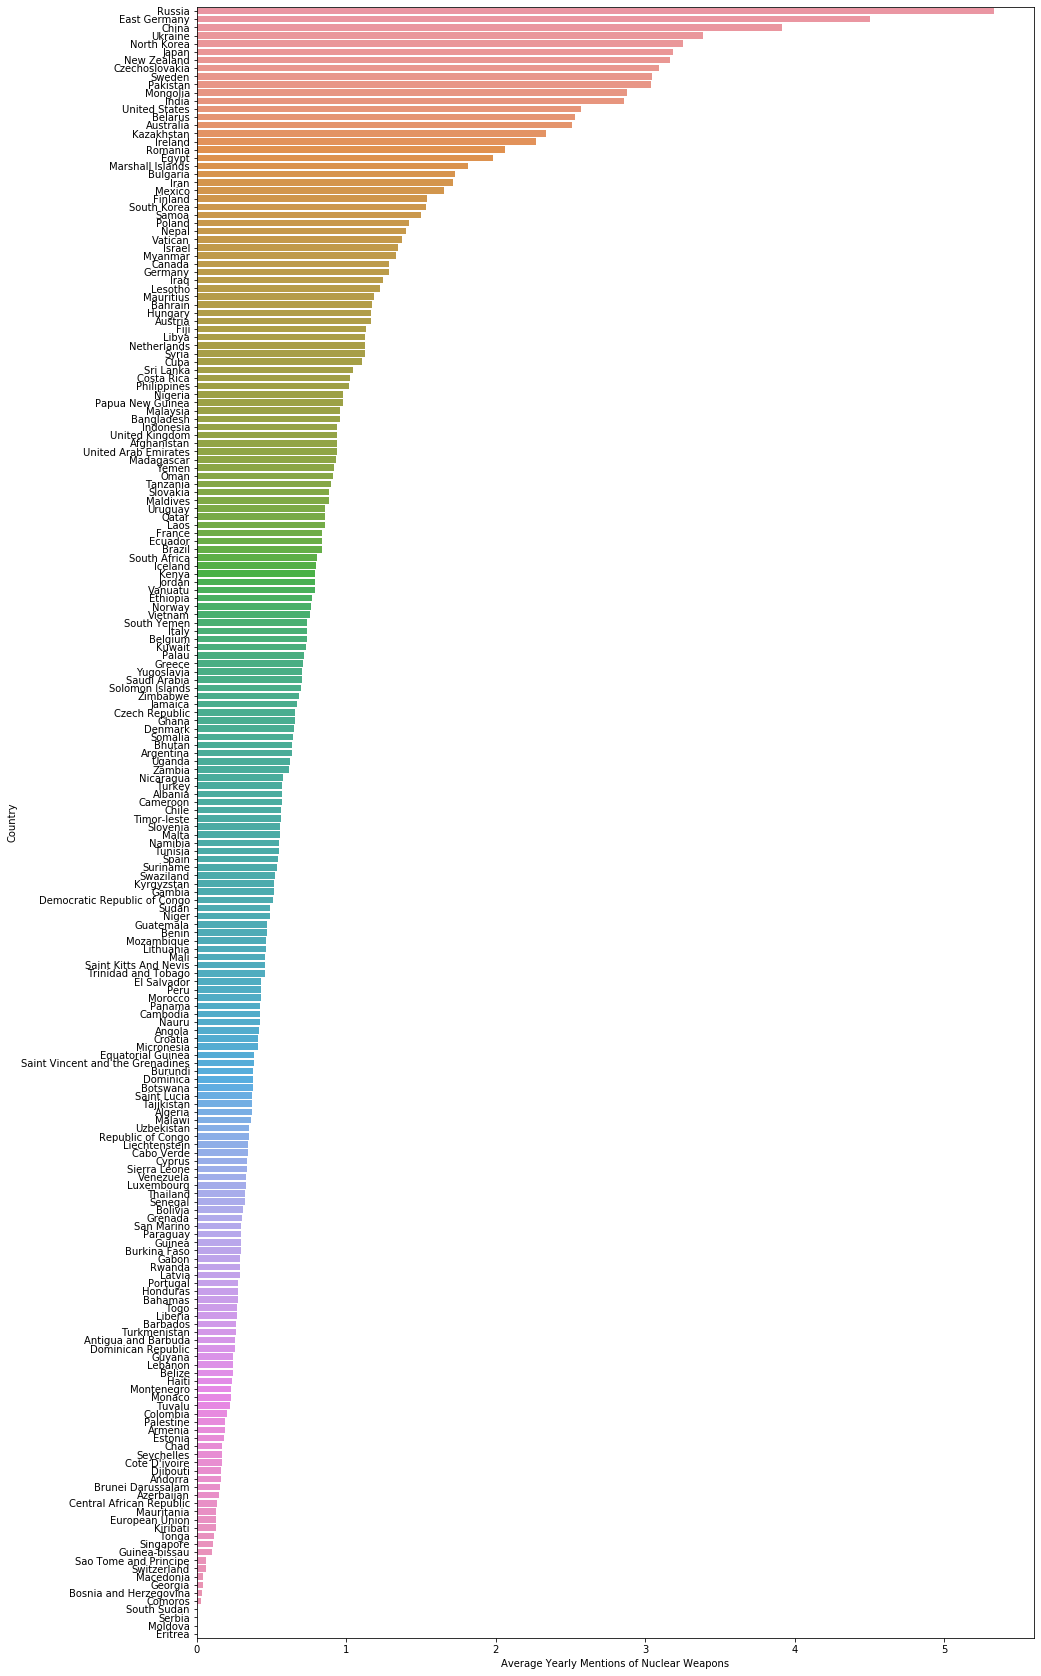

In [31]:
# Visualizing Mentions of Nuclear Weapons by Country

# Graphically, the above series looks something like this
plt.figure(figsize=(15, 30))
fig2 = sns.barplot(y=avg_nuke_mentions.index,x=avg_nuke_mentions.values, orient = 'h')
fig2.set(xlabel='Average Yearly Mentions of Nuclear Weapons', ylabel='Country') # I'm not sure why this line randomly prints a bunch of output text

In [32]:
## Tracking Mentions of Nuclear Weapons in the UNGD

# We're now going to repeat the above analysis, but switching the focus from nuclear weapons to climate change.

len(matcher) # Shows that the matcher object still has the nuke terms from above
matcher.remove('nuke_terms')

climate_terms = ['climate change', 'global warming','carbon emissions']
patterns = [nlp.make_doc(text) for text in climate_terms]
matcher.add('climate_terms', None, *patterns)
len(matcher)==1 # Should result in True

True

In [33]:
df['climate_mentions'] = df['doc_obj'].progress_apply(lambda x: len(matcher(x)))
df

Progress: 100%|█████████████████████████████████████████████████████████████████| 8093/8093 [00:00<00:00, 15009.22it/s]


,country_code,country_name,year,proc_text,doc_obj,nuke_mentions,climate_mentions
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ...",0,0
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha...",0,0
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c...",0,0
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to...",1,0
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f...",4,0
...,...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...",0,0
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...",0,0
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...",0,0
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...",0,5


[Text(0, 0.5, 'Total Mentions of Climate Change'), Text(0.5, 0, 'Year')]

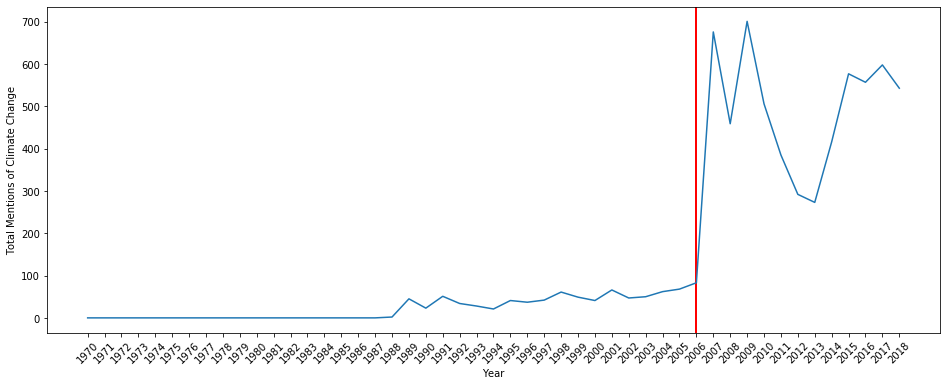

In [34]:
# Visualizing Mentions of Climate Change in the UNGD over Time

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(36,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig3 = sns.lineplot(data=df, x='year', y='climate_mentions', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig3.set(xlabel='Year', ylabel='Total Mentions of Climate Change') # Not sure why this line randomly prints some text at the beginning

In [35]:
# I'm not saying that it's the only factor, but 2006 was the year Al Gore's "An Inconvenient Truth" was released.
# Gore and the Inter-Governmental Panel on Climate Change (IPCC) jointly won the Nobel Peace Prize in 2007.

# In what year, and by which countries, was climate change first brought up in a UN General Debate session?

df_climate = df[df['climate_mentions'] != 0].drop(columns=['proc_text','doc_obj','nuke_mentions','country_code'])
df_climate.groupby(['year'])
df_climate.sort_values(by=['year']).head(30)

,country_name,year,climate_mentions
1258,Canada,1988,2
901,Belize,1989,2
3797,Japan,1989,2
999,Brazil,1989,1
1728,Costa Rica,1989,1
3554,Iceland,1989,1
7624,United States,1989,1
5548,Nepal,1989,3
1847,Cyprus,1989,1
291,Antigua and Barbuda,1989,2


In [36]:
# In what year did the greatest number of countries mention climate change?

df_climate.groupby(['year'])['country_name'].nunique().sort_values(ascending=False).head()

year
2009    169
2007    160
2017    157
2016    153
2010    149
Name: country_name, dtype: int64

In [37]:
# In 2009, what percentage of all countries present that year mentioned climate change?

num_countries_2009 = df[df['year']=='2009']['country_name'].nunique()
result2 = (169 / num_countries_2009)
result2

0.8756476683937824

In [42]:
# On average, which countries most and least frequently mention climate change?

# Before we can answer this question, we should realize that we don't want to calulate an average yearly value over the entire dataframe,
# since climate change was not officially recognized by any UN member until 1988.
# Accordingly, in order to get the true average values, we want to only consider a subset of the dataframe post-1987.

df_post_1987 = df.astype({'year': 'int64'}) # This column was originally a string, but changing it to an integer allows us to perform a mathematical operation in the next line.
df_post_1987 = df_post_1987[df_post_1987['year']>1987] # Selects only the rows in our dataframe after 1987
df_post_1987

,country_code,country_name,year,proc_text,doc_obj,nuke_mentions,climate_mentions
17,AFG,Afghanistan,1988,﻿It gives me great pleasure to express to Mt. ...,"(﻿It, gives, me, great, pleasure, to, express,...",3,0
18,AFG,Afghanistan,1989,﻿ It gives me pleasure at the very outset to c...,"(﻿, It, gives, me, pleasure, at, the, very, ou...",1,0
19,AFG,Afghanistan,1990,"﻿Allow me, first of all, Sir, to congratulate ...","(﻿Allow, me, ,, first, of, all, ,, Sir, ,, to,...",1,0
20,AFG,Afghanistan,1991,﻿At the outset I wish to convey to Ambassador ...,"(﻿At, the, outset, I, wish, to, convey, to, Am...",0,0
21,AFG,Afghanistan,1992,I shall read out the following statement on be...,"(I, shall, read, out, the, following, statemen...",1,0
...,...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...",0,0
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...",0,0
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...",0,0
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...",0,5


In [43]:
avg_climate_mentions = df_post_1987.groupby(['country_name'])['climate_mentions'].mean().sort_values(ascending=False)
avg_climate_mentions.rename('avg_climate_mentions',inplace=True)

country_name
Tuvalu            11.555556
Kiribati           9.500000
Micronesia         7.555556
Samoa              7.269231
Palau              5.809524
                    ...    
Israel             0.032258
South Yemen        0.000000
Czechoslovakia     0.000000
Yugoslavia         0.000000
East Germany       0.000000
Name: avg_climate_mentions, Length: 200, dtype: float64

[Text(0, 0.5, 'Country'),
 Text(0.5, 0, 'Average Yearly Mentions of Climate Change')]

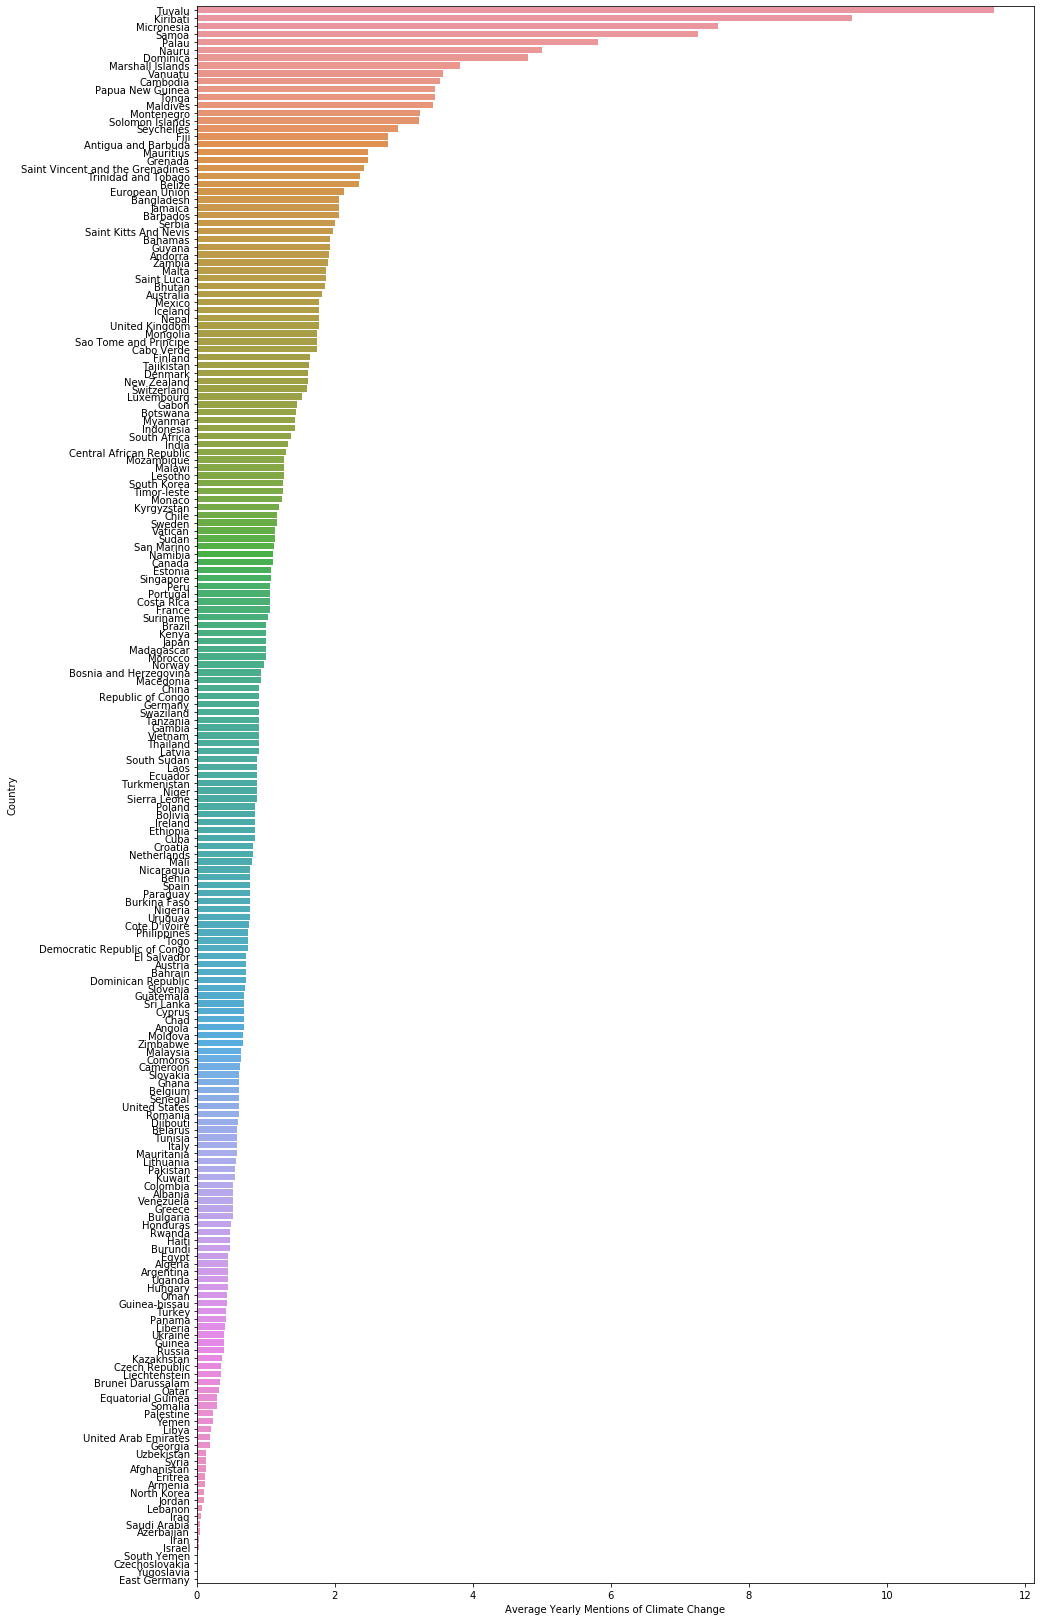

In [44]:
# Unsurprisingly, small island nations which face existential threats from rising sea levels mention climate change a lot. 
# Equally unsurprisingly, countries which ceased to exist prior to the mid-2000s never mentioned climate change.

# Visualizing Mentions of Climate Change by Country

plt.figure(figsize=(15, 29))
fig4 = sns.barplot(y=avg_climate_mentions.index,x=avg_climate_mentions.values, orient = 'h')
fig4.set(xlabel='Average Yearly Mentions of Climate Change', ylabel='Country') # Not sure why it randomly prints a line of text

In [45]:
## Plotting Mentions of Nukes vs. Climate Change Side-by-Side

# First let's reformat our existing dataframe by dropping all columns except 'nuke_mentions' and 'climate_mentions' and then sum up each row by the 'year' column
df_simple = df.drop(columns=['doc_obj','proc_text','country_code','country_name']).groupby('year').sum()
df_simple.head(10)

,nuke_mentions,climate_mentions
year,,
1970,103,0
1971,100,0
1972,199,0
1973,122,0
1974,197,0
1975,243,0
1976,173,0
1977,250,0
1978,228,0


[Text(0, 0.5, 'Total Mentions'), Text(0.5, 0, 'Year')]

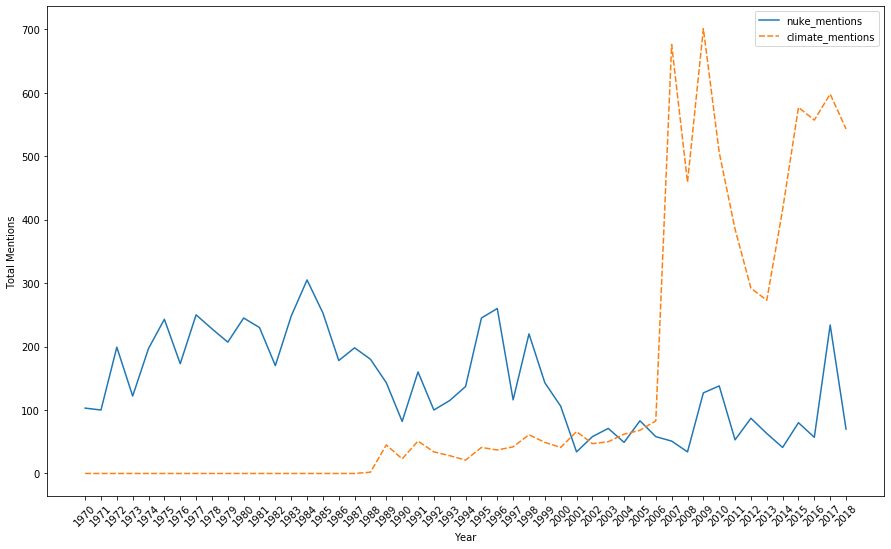

In [46]:
# We can then use Seaborn to easily plot the entire dataset in one fell swoop
plt.figure(figsize=(15, 9))
plt.xticks(rotation=45)
fig5 = sns.lineplot(data=df_simple)
fig5.set(xlabel='Year', ylabel='Total Mentions')

In [47]:
## Application 2: Linguistic Similarity Analysis

# SpaCy can automatically calculate the similarity of two documents based on the words they contain.
# (For a brief explanation of the math underlying word vectorization, see: https://towardsdatascience.com/understanding-nlp-word-embeddings-text-vectorization-1a23744f7223)

# Let's look at some examples.
# In 2015 (the year before the Brexit referendum), was the UK's speech more similar to the EU's speech or to the US' speech?

target_doc = df[(df['country_code']=='GBR') & (df['year']=='2015')]['doc_obj'].to_list()[0]
 
comparison_doc1 = df[(df['country_code']=='EU_') & (df['year']=='2015')]['doc_obj'].to_list()[0]
comparison_doc2 = df[(df['country_code']=='USA') & (df['year']=='2015')]['doc_obj'].to_list()[0]

print("The 2015 British text's similarity with that year's EU text is: "+str(target_doc.similarity(comparison_doc1)))
print("The 2015 British text's similarity with that year's US text is: "+str(target_doc.similarity(comparison_doc2)))

The 2015 British text's similarity with that year's EU text is: 0.9942037492403605
The 2015 British text's similarity with that year's US text is: 0.9937062509615697


In [48]:
# Similarity scores always range from 0 (no lingustic similarity) to 1 (exactly the same word vectors used).

# The first thing to note about the scores above is the high degree of linguistic similarity across all the documents,
# which isn't that suprising once you realize that they are all similarly structured speeches addressed to the same audience on roughly similar topics.

# Still, at least for 2015, it seems that the UK's speech was still a tad more similar to the EU's than the US'.
# Was that still the case in 2018 (the last year for which data is available, in the throes of Brexit)?

target_doc = df[(df['country_code']=='GBR') & (df['year']=='2018')]['doc_obj'].to_list()[0]
 
comparison_doc1 = df[(df['country_code']=='EU_') & (df['year']=='2018')]['doc_obj'].to_list()[0]
comparison_doc2 = df[(df['country_code']=='USA') & (df['year']=='2018')]['doc_obj'].to_list()[0]

print("The 2018 British text's similarity with that year's EU text is: "+str(target_doc.similarity(comparison_doc1)))
print("The 2018 British text's similarity with that year's US text is: "+str(target_doc.similarity(comparison_doc2)))

The 2018 British text's similarity with that year's EU text is: 0.9947567392787887
The 2018 British text's similarity with that year's US text is: 0.9953390033465181


In [49]:
## Linguistic Similarity Analysis Over Time

# Building upon the above, we can systematically track shifts in a country's discourse over time.

# Consider the long-running debate about whether Russia is more of a European country or more of an Asian country.
# Some have argued that since at least Peter the Great, Russia's leaders have looked westward towards Europe for their civilaztional identity.
# Others have pointed out that the rise of Asia in world politics in the late 20th century has caused Russian leaders to embrace their Asian identity as never before.
# Still others have suggested that perhaps Russia can have its cake and eat it as well by doing *both*: identifying as European and Asian simultaneously.
#(See, for example: https://slate.com/news-and-politics/2017/02/can-russia-be-european-and-asian.html)

# To offer one possible answer to this question, we will compare the similarity of the Russian speech every year with the average of two sample peer groups
# In the European peer group, we will include (West) Germany, France, Italy, and Spain.
# In the Asian peer group, we will include China, South Korea, Japan, and Mongolia.

## (Note that the next several cells involve data-wrangling done in a particularly un-Pythonic way. There's definitely a better way to set this up, but I haven't sat down to think it through yet.)

df_lsa = df[df['country_code']=='RUS'].drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_lsa = df_lsa.rename(columns={'doc_obj': 'RUS_doc_obj'})
df_lsa = df_lsa.reset_index(drop=True)
df_lsa.head()

,year,RUS_doc_obj
0,1971,"( , First, of, all, ,, Mr., President, ,, I, ..."
1,1972,"(Comrade, President, ,, allow, me, first, of, ..."
2,1973,"(﻿, , Mr., President, ,, on, behalf, of, the,..."
3,1974,"(Mr., President, ,, on, behalf, of, the, Sovie..."
4,1975,"( , Mr., President, ,, on, behalf, of, the, d..."


In [53]:
# The country codes we want: ['RUS','DEU','FRA','ITA','ESP','CHN','IND','JPN','MNG']

df_DEU = df[df['country_code']=='DEU'].reset_index(drop=True)
df_DEU = df_DEU.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_DEU = df_DEU.rename(columns={'doc_obj': 'DEU_doc_obj'})

df_FRA = df[df['country_code']=='FRA'].reset_index(drop=True)
df_FRA = df_FRA.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_FRA = df_FRA.rename(columns={'doc_obj': 'FRA_doc_obj'})

df_ITA = df[df['country_code']=='ITA'].reset_index(drop=True)
df_ITA = df_ITA.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_ITA = df_ITA.rename(columns={'doc_obj': 'ITA_doc_obj'})

df_ESP = df[df['country_code']=='ESP'].reset_index(drop=True)
df_ESP = df_ESP.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_ESP = df_ESP.rename(columns={'doc_obj': 'ESP_doc_obj'})

df_CHN = df[df['country_code']=='CHN'].reset_index(drop=True)
df_CHN = df_CHN.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_CHN = df_CHN.rename(columns={'doc_obj': 'CHN_doc_obj'})

df_IND = df[df['country_code']=='IND'].reset_index(drop=True)
df_IND = df_IND.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_IND = df_IND.rename(columns={'doc_obj': 'IND_doc_obj'})

df_JPN = df[df['country_code']=='JPN'].reset_index(drop=True)
df_JPN = df_JPN.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_JPN = df_JPN.rename(columns={'doc_obj': 'JPN_doc_obj'})

df_MNG = df[df['country_code']=='MNG'].reset_index(drop=True)
df_MNG = df_MNG.drop(columns=['proc_text','nuke_mentions','climate_mentions','country_name','country_code'])
df_MNG = df_MNG.rename(columns={'doc_obj': 'MNG_doc_obj'})

df_DEU.head()
#df_FRA.head()
#df_ITA.head()
#df_ESP.head()
#df_CHN.head()
#df_IND.head()
#df_JPN.head()
#df_MNG.head()

,year,DEU_doc_obj
0,1973,"(﻿Mr, ., President, ,, let, me, begin, by, con..."
1,1974,"(Mr., President, ,, let, me, begin, by, congra..."
2,1975,"(Since, the, founding, of, the, United, Nation..."
3,1976,"(The, delegation, of, the, Federal, Republic, ..."
4,1977,"(﻿, , Mr., President, ,, I, should, like, fir..."


In [54]:
df_lsa = df_lsa.merge(df_DEU,how='left')
df_lsa = df_lsa.merge(df_FRA,how='left')
df_lsa = df_lsa.merge(df_ITA,how='left')
df_lsa = df_lsa.merge(df_ESP,how='left')
df_lsa = df_lsa.merge(df_CHN,how='left')
df_lsa = df_lsa.merge(df_IND,how='left')
df_lsa = df_lsa.merge(df_JPN,how='left')
df_lsa = df_lsa.merge(df_MNG,how='left')
df_lsa

# Note that we start in 1971 instead of 1970 because there was no Russian speech that year (I am not sure why that's the case)
# We are also missing the first two West German speeches, but it should not affect the overall analysis.

,year,RUS_doc_obj,DEU_doc_obj,FRA_doc_obj,ITA_doc_obj,ESP_doc_obj,CHN_doc_obj,IND_doc_obj,JPN_doc_obj,MNG_doc_obj
0,1971,"( , First, of, all, ,, Mr., President, ,, I, ...",NaN,"( , It, is, toward, Asia, where, all, the, pro...","( , Mr., President, on, behalf, of, the, Ital...","( , Mr., President, ,, in, this, first, inter...","( , Mr., President, ,, it, is, my, pleasant,...","( , Mr., President, ,, on, behalf, of, the, pe...","( , On, behalf, of, the, Japanese, delegation...","( , Mr., President, ,, may, I, ,, on, behalf..."
1,1972,"(Comrade, President, ,, allow, me, first, of, ...",NaN,"(The, first, word, I, should, like, to, mentio...","(Mr., President, ,, it, is, a, privilege, for,...","(Mr., President, ,, before, addressing, this, ...","(A, number, of, important, changes, have, take...","(Mr., President, ,, I, offer, you, on, behalf,...","(Mr., President, ,, on, behalf, of, the, Japan...","(Comrade, President, ,, first, of, all, I, sho..."
2,1973,"(﻿, , Mr., President, ,, on, behalf, of, the,...","(﻿Mr, ., President, ,, let, me, begin, by, con...","(﻿, Mr., President, ,, in, these, last, days, ...","(﻿, , Mr., President, ,, may, I, be, allowed,...","(﻿, Mr., President, ,, it, is, for, me, a, ver...","(﻿Since, the, twenty, -, seventh, session, of,...","(﻿, Mr., President, ,, I, bring, to, you, and,...","(﻿, , On, behalf, of, the, Japanese, delegati...","(﻿, , Mr., President, ,, allow, me, ,, on, ..."
3,1974,"(Mr., President, ,, on, behalf, of, the, Sovie...","(Mr., President, ,, let, me, begin, by, congra...","(Sir, ,, my, first, words, will, be, to, offer...","( , Mr., President, ,, I, should, like, first...","(As, representative, of, Spain, to, this, sess...","(Mr., President, ,, first, of, all, ,, I, shou...","(Mr., President, ,, I, have, already, had, occ...","(Mr., President, ,, on, behalf, of, the, Japan...","(Mr., President, ,, the, delegation, of, the, ..."
4,1975,"( , Mr., President, ,, on, behalf, of, the, d...","(Since, the, founding, of, the, United, Nation...","( , Mr., President, ,, it, is, with, great, p...","(﻿In, beginning, my, statement, ,, I, should, ...","( , Mr., President, ,, first, of, all, ,, I,...","( , Profound, changes, have, taken, place, in,...","( , It, is, my, privilege, and, pleasure, ,, ...","(the, major, Powers, ., With, the, emergence, ...","( , The, delegation, of, the, Mongolian, Peop..."
5,1976,"(On, behalf, of, the, Soviet, delegation, I, s...","(The, delegation, of, the, Federal, Republic, ...","(Mr., President, ,, first, of, all, I, should,...","(In, speaking, for, the, first, time, from, th...","(Mr., President, ,, allow, me, to, say, a, few...","(We, ,, the, delegation, of, the, People, 's, ...","(Let, me, begin, by, extending, to, the, Presi...","(On, behalf, of, the, Japanese, delegation, I,...","(Allow, me, ,, on, behalf, of, the, delegation..."
6,1977,"(﻿, , Mr., President, ,, on, behalf, of, the,...","(﻿, , Mr., President, ,, I, should, like, fir...","(﻿, , Mr., President, ,, there, are, many, re...","(﻿, , Mr., President, ,, allow, me, ,, first,...","(﻿, , Mr., President, ,, my, first, words, wi...","(﻿, , Mr., President, ,, I, would, like, to, ...","(﻿, India, recently, accomplished, a, historic...","(﻿, , Mr., President, ,, on, behalf, of, the,...","(﻿, Comrade, President, ,, 1, have, already, h..."
7,1978,"(﻿, Mr., President, ,, the, delegation, of, th...","(﻿, The, Federal, Republic, of, Germany, at, p...","(﻿, , Mr., President, ,, it, is, a, pleasure,...","(﻿, , Mr, President, ,, it,...","(﻿, , It, is, our, privilege, to, have, as, o...","(﻿, I, would, like, to, begin, my, speech, by,...","(﻿, , Mr., President, ,, may, I, extend, ...","(﻿, , On, behalf, of, ...","(﻿, Mr., President, ,, the, delegation, of, th..."
8,1979,"(﻿Mr, ., President, ,, allow, me, to, congratu...","(﻿First, of, all, ,, I, should, like, ,, on, b...","(﻿The, sole, aim, of, our, General, Assembly, ...","(﻿May, I, convey, to, the, President, my, warm...","(﻿This, year, we, have, the, good, fortune, 

In [55]:
RUS_list = df_lsa['RUS_doc_obj'].to_list()
DEU_list = df_lsa['DEU_doc_obj'].to_list()
FRA_list = df_lsa['FRA_doc_obj'].to_list()
ITA_list = df_lsa['ITA_doc_obj'].to_list()
ESP_list = df_lsa['ESP_doc_obj'].to_list()
CHN_list = df_lsa['CHN_doc_obj'].to_list()
IND_list = df_lsa['IND_doc_obj'].to_list()
JPN_list = df_lsa['JPN_doc_obj'].to_list()
MNG_list = df_lsa['MNG_doc_obj'].to_list()

similarity_to_FRA = []
for number in range(0,len(RUS_list)):
    doc1, doc2 = RUS_list[number], FRA_list[number]
    similarity_to_FRA.append(doc1.similarity(doc2))
df_lsa['similarity_to_FRA'] = similarity_to_FRA

similarity_to_DEU = [np.nan,np.nan]
for number in range(2,len(RUS_list)):  # Note that we start at 2 here to skip the first two rows
    doc1, doc2 = RUS_list[number], DEU_list[number]
    similarity_to_DEU.append(doc1.similarity(doc2))
df_lsa['similarity_to_DEU'] = similarity_to_DEU

similarity_to_ITA = []
for number in range(0,len(RUS_list)):
    doc1, doc2 = RUS_list[number], ITA_list[number]
    similarity_to_ITA.append(doc1.similarity(doc2))
df_lsa['similarity_to_ITA'] = similarity_to_ITA

similarity_to_ESP = []
for number in range(0,len(RUS_list)):
    doc1, doc2 = RUS_list[number], ESP_list[number]
    similarity_to_ESP.append(doc1.similarity(doc2))
df_lsa['similarity_to_ESP'] = similarity_to_ESP

similarity_to_CHN = []
for number in range(0,len(RUS_list)):
    doc1, doc2 = RUS_list[number], CHN_list[number]
    similarity_to_CHN.append(doc1.similarity(doc2))
df_lsa['similarity_to_CHN'] = similarity_to_CHN

similarity_to_IND = []
for number in range(0,len(RUS_list)):
    doc1, doc2 = RUS_list[number], IND_list[number]
    similarity_to_IND.append(doc1.similarity(doc2))
df_lsa['similarity_to_IND'] = similarity_to_IND

similarity_to_JPN = []
for number in range(0,len(RUS_list)):
    doc1, doc2 = RUS_list[number], JPN_list[number]
    similarity_to_JPN.append(doc1.similarity(doc2))
df_lsa['similarity_to_JPN'] = similarity_to_JPN

similarity_to_MNG = []
for number in range(0,len(RUS_list)):
    doc1, doc2 = RUS_list[number], MNG_list[number]
    similarity_to_MNG.append(doc1.similarity(doc2))
df_lsa['similarity_to_MNG'] = similarity_to_MNG

df_lsa

,year,RUS_doc_obj,DEU_doc_obj,FRA_doc_obj,ITA_doc_obj,ESP_doc_obj,CHN_doc_obj,IND_doc_obj,JPN_doc_obj,MNG_doc_obj,similarity_to_FRA,similarity_to_DEU,similarity_to_ITA,similarity_to_ESP,similarity_to_CHN,similarity_to_IND,similarity_to_JPN,similarity_to_MNG
0,1971,"( , First, of, all, ,, Mr., President, ,, I, ...",NaN,"( , It, is, toward, Asia, where, all, the, pro...","( , Mr., President, on, behalf, of, the, Ital...","( , Mr., President, ,, in, this, first, inter...","( , Mr., President, ,, it, is, my, pleasant,...","( , Mr., President, ,, on, behalf, of, the, pe...","( , On, behalf, of, the, Japanese, delegation...","( , Mr., President, ,, may, I, ,, on, behalf...",0.993825,NaN,0.997160,0.997299,0.995153,0.995703,0.996563,0.994919
1,1972,"(Comrade, President, ,, allow, me, first, of, ...",NaN,"(The, first, word, I, should, like, to, mentio...","(Mr., President, ,, it, is, a, privilege, for,...","(Mr., President, ,, before, addressing, this, ...","(A, number, of, important, changes, have, take...","(Mr., President, ,, I, offer, you, on, behalf,...","(Mr., President, ,, on, behalf, of, the, Japan...","(Comrade, President, ,, first, of, all, I, sho...",0.992432,NaN,0.997108,0.995555,0.996803,0.995386,0.997190,0.997881
2,1973,"(﻿, , Mr., President, ,, on, behalf, of, the,...","(﻿Mr, ., President, ,, let, me, begin, by, con...","(﻿, Mr., President, ,, in, these, last, days, ...","(﻿, , Mr., President, ,, may, I, be, allowed,...","(﻿, Mr., President, ,, it, is, for, me, a, ver...","(﻿Since, the, twenty, -, seventh, session, of,...","(﻿, Mr., President, ,, I, bring, to, you, and,...","(﻿, , On, behalf, of, the, Japanese, delegati...","(﻿, , Mr., President, ,, allow, me, ,, on, ...",0.989319,0.996165,0.996106,0.996946,0.996494,0.997369,0.995920,0.993018
3,1974,"(Mr., President, ,, on, behalf, of, the, Sovie...","(Mr., President, ,, let, me, begin, by, congra...","(Sir, ,, my, first, words, will, be, to, offer...","( , Mr., President, ,, I, should, like, first...","(As, representative, of, Spain, to, this, sess...","(Mr., President, ,, first, of, all, ,, I, shou...","(Mr., President, ,, I, have, already, had, occ...","(Mr., President, ,, on, behalf, of, the, Japan...","(Mr., President, ,, the, delegation, of, the, ...",0.996705,0.997777,0.998058,0.997895,0.996351,0.998007,0.997612,0.993469
4,1975,"( , Mr., President, ,, on, behalf, of, the, d...","(Since, the, founding, of, the, United, Nation...","( , Mr., President, ,, it, is, with, great, p...","(﻿In, beginning, my, statement, ,, I, should, ...","( , Mr., President, ,, first, of, all, ,, I,...","( , Profound, changes, have, taken, place, in,...","( , It, is, my, privilege, and, pleasure, ,, ...","(the, major, Powers, ., With, the, emergence, ...","( , The, delegation, of, the, Mongolian, Peop...",0.997264,0.998149,0.997889,0.997332,0.996440,0.998452,0.996711,0.995725
5,1976,"(On, behalf, of, the, Soviet, delegation, I, s...","(The, delegation, of, the, Federal, Republic, ...","(Mr., President, ,, first, of, all, I, should,...","(In, speaking, for, the, first, time, from, th...","(Mr., President, ,, allow, me, to, say, a, few...","(We, ,, the, delegation, of, the, People, 's, ...","(Let, me, begin, by, extending, to, the, Presi...","(On, behalf, of, the, Japanese, delegation, I,...","(Allow, me, ,, on, behalf, of, the, delegation...",0.997246,0.997480,0.996308,0.997422,0.993351,0.998132,0.997073,0.991869
6,1977,"(﻿, , Mr., President, ,, on, behalf, of, the,...","(﻿, , Mr., President, ,, I, should, like, fir...","(﻿, , Mr., President, ,, there, are, many, re...","(﻿, , Mr., President, ,, allow, me, ,, first,...","(﻿, , Mr., President, ,, my, first, words, wi...","(﻿, , Mr., President, ,, I, would, like, to, ...","(﻿, India, recently, accomplished, a, historic...","(﻿, , Mr., President, ,, on, behalf, of, the,...","(﻿, Comrade, President, ,, 1, have, already, h...",0.998486,0.996209,0.996190,0.996884,0.993327,0.996967,0.995215,0.992405
7,1978,"(﻿, Mr., President, ,, the, delegation,

In [56]:
df_lsa2 = df_lsa.drop(columns=['RUS_doc_obj','FRA_doc_obj','JPN_doc_obj','DEU_doc_obj','ITA_doc_obj','ESP_doc_obj','CHN_doc_obj','IND_doc_obj','MNG_doc_obj'])
df_lsa2 = df_lsa2.set_index(['year'])
df_lsa2.head()

,similarity_to_FRA,similarity_to_DEU,similarity_to_ITA,similarity_to_ESP,similarity_to_CHN,similarity_to_IND,similarity_to_JPN,similarity_to_MNG
year,,,,,,,,
1971,0.993825,NaN,0.997160,0.997299,0.995153,0.995703,0.996563,0.994919
1972,0.992432,NaN,0.997108,0.995555,0.996803,0.995386,0.997190,0.997881
1973,0.989319,0.996165,0.996106,0.996946,0.996494,0.997369,0.995920,0.993018
1974,0.996705,0.997777,0.998058,0.997895,0.996351,0.998007,0.997612,0.993469
1975,0.997264,0.998149,0.997889,0.997332,0.996440,0.998452,0.996711,0.995725


In [ ]:
# Plot each of these columns as individual lines on a same figure (ideally in Plotly) to see what's going on behind the scenes.
# Then say, "but actually, this is hard to visualize, so let's collapse it just down to two."

In [58]:
df_lsa2['avg_similarity_to_Europe'] = df_lsa2[['similarity_to_DEU','similarity_to_FRA', 'similarity_to_ITA','similarity_to_ESP']].mean(axis=1)
df_lsa2['avg_similarity_to_Asia'] = df_lsa2[['similarity_to_CHN', 'similarity_to_IND','similarity_to_JPN','similarity_to_MNG']].mean(axis=1)
df_lsa3 = df_lsa2.drop(columns=['similarity_to_DEU','similarity_to_FRA', 'similarity_to_ITA','similarity_to_ESP','similarity_to_CHN','similarity_to_IND','similarity_to_JPN','similarity_to_MNG'])
df_lsa3.head()

,avg_similarity_to_Europe,avg_similarity_to_Asia
year,,
1971,0.996094,0.995585
1972,0.995032,0.996815
1973,0.994634,0.995700
1974,0.997609,0.996360
1975,0.997659,0.996832


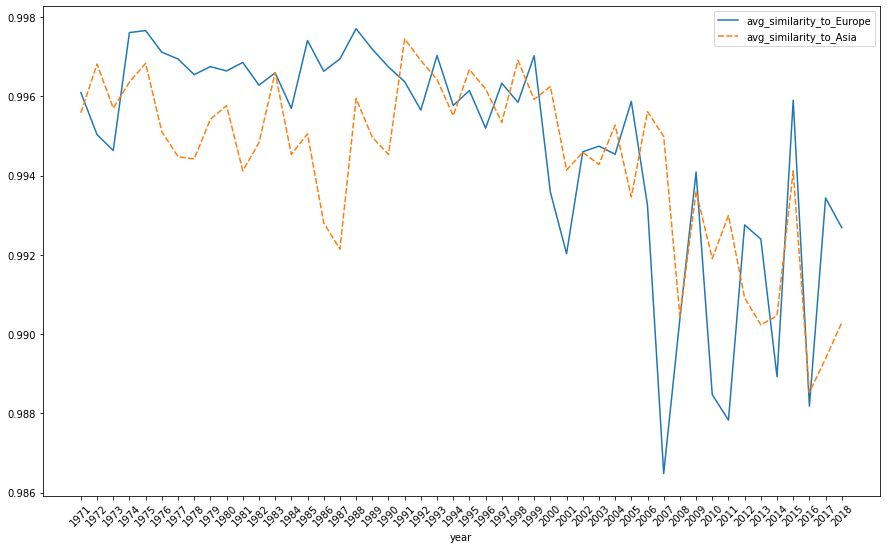

In [59]:
plt.figure(figsize=(15, 9))
plt.xticks(rotation=45)
fig6 = sns.lineplot(data=df_lsa3)

In [ ]:
# So...  the answer is neither??
# It would appear that since roughly 2000, Russia has linguistically been moving away from both common European and Asian discourses.
# We might say that since the rise to power of President Vladimir Putin, Russia has increasingly been marching to the beat of its own drum.
# While the Soviet Union sounded very much like a European country during the Cold War (.998## similarity at its peak in 19##), that is no longer the case, with a sharp drop in linguistic similarity in the mid-2000s.
# What is also clear is that Russian discourse at the UNGD has been more erratic in the post-Cold War era, with greater shifts from year to year.

## Visually mark on the figure: Putin comes to power in 2000, invasion of Crimea in 2014.
## Interestingly, however, dissolution of Soviet Union in 1989-1991 doesn't have much effect.

In [61]:
## Application 3: Using NER to Model a Simple Network

## Visualizing Named Entity Recognition (NER) in Individual Doc_Objs

displacy_options = {'ents': ['PERSON','NORP','FAC','ORG','GPE','LOC','EVENT','LAW','LANGUAGE']}
# The above activates some of Spacy's built-in entity categories, but not all of them.
# For all the options, see: https://spacy.io/usage/visualizers#ent)

displacy.render(df[(df['country_code']=='CUB') & (df['year']=='1979')]['doc_obj'],
                style='ent', options = displacy_options,jupyter=True)

In [62]:
## THIS CELL CURRENTLY DOES NOT WORK LIKE IT SHOULD
# I'm not sure exactly why, but it seems the export features work better for the parse visualizer than the NER visualizer

# You can save the output of doing an NER visualization as an HTML file with these steps
doc_to_export = df[(df['country_code']=='USA') & (df['year']=='2003')]['doc_obj'].to_list()[0]

html = displacy.render(doc_to_export, style="ent", options = displacy_options, page=True, minify=False)
file_name = '_'.join(country_code,year)+'.html'
output_path = Path('C:\\Users\\nicol\\Desktop\\Data Science Stuff\\UNGDC\\Exported HTMLs\\' + file_name)
output_path.open('w', encoding='utf-8').write(html)

NameError: name 'country_code' is not defined

In [ ]:
# You can access the recognized entities in a doc object by calling:
df[(df['country_code']=='LTU') & (df['year']=='2013')]['doc_obj'].to_list()[0].ents

In [ ]:
## CELL NOT CURRENTLY WORKING
## Visualizing Custom NERs

# As we just saw, Canada was the first country to mention 'climate change' at a UN General Debate.
# Below we present the text of that speech, with all mentions of climate change and nuclear weapons highlighted.
# To automatically do the highlighting, we create two new NERs.

ner = nlp.get_pipe("ner")
ner.add_label('nuclear')
ner.add_label('climate')

#canada_doc = nlp(df[(df['country_code']=='CAN') & (df['year']=='1988')]['proc_text'])
#displacy.render(canada_doc, style='ent', jupyter=True)

displacy.render(df[(df['country_code']=='CAN') & (df['year']=='1988')]['doc_obj'],
                style='ent', options = displacy_options, jupyter=True)

In [23]:
## Visualizing the UNGD as a Network of Country Mentions

# Now let's try to use a simple network visualization package to analyze how often each UN member refers to every other UN member.
# For every year, our nodes will be countries and the width of our edges will be the number of mentions.

# We begin by grabbing all the relevant NERs in the corpus

ent_types = ['PERSON','NORP','FAC','ORG','GPE','LOC','LAW','LANGUAGE']
political_ents = []
for ent in df[(df['country_code']=='LTU') & (df['year']=='2013')]['doc_obj'].to_list()[0].ents:
    if ent.label_ in ent_types:
        political_ents.append(ent)
political_ents # Do I want it in the form of a tuple?

[the Millennium  Development Goals,
 the Millennium  Development Goals,
 post-2015,
 Assembly,
 the Baltic States,
 Vilnius,
 Eastern,
 European,
 States,
 the European Union,
 Lithuania,
 the Council of the European Union,
 post-2015,
 the  United Nations]

In [ ]:
# To allow for subsequent analysis, let's create a new column in our df for relevant entities in each speech
df['ents'] = df['doc_obj'].progress_apply(lambda x: x.ents)
df

## The above currently works, but what I'd really like is to do something like the below
#ent_types = ['PERSON','NORP','FAC','ORG','GPE','LOC','EVENT','LAW','LANGUAGE']
#df['ents'] = df['doc_obj'].progress_apply(lambda x: x.ents if ent.label_ in ent_types)
#df

In [ ]:
## STILL TO DO

# Leverage Plotly's incredibly powerful NER capabilities to empirically show which country talk about which countries over time - should open the door for a publishable network analysis

# Add titles to my visualizations

# Way up at the top of this thing, change my 'year' variable from a string to an integer to allow for mathematical operations.
# Will entail minor edits to a lot of cells, though.

# Write a custom training script to improve the NER feature?
# Look at: https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/
# https://medium.com/python-in-plain-english/a-closer-look-at-entityruler-in-spacy-rule-based-matching-44d01c43fb6

# Do a better job of annotating my timelines

# Make the side-by-side nukes vs. cimate change visualization prettier

# Figure out what the most distinctive tokens are in a given year?
# Either the ones that get mentioned the most relative to a baseline, or the ones being mentioned for the first time that year?

# Plot mentions of climate change relative to exposure to climate change??  Perhaps by risk-tier, otherwise it's not going to be that surprising??

# Look into the names of those websites that 'grade' your code

# At the end of the script, save the df in some way so that you don't have to run through everything all over again.

In [45]:
## Appendix 1: Phrase Matching Considerations in NLP

# Decisions about how exactly you do phrase matching can significantly affect your findings.

# Below I present two different ways of doing the matching analysis to get the count of nuclear weapons mentions.

# A good sample text to make sure the pattern is picking up true positives and skipping false negatives is KOR_49_1994


## Option 1: Broader, But More Likely to Grab False Positives
# We use SpaCy's Matcher method to check each document for specific terms and phrases.

matcher1 = Matcher(nlp.vocab)
matcher1.add('nuke_mentions', None,
            [{'LOWER': 'nuclear'}],
            [{'LOWER': 'atomic'}])
df['nuke_mentions_matcher1'] = df['doc_obj'].progress_apply(lambda x: len(matcher1(x)))

## Pros of the method: will capture basically anything related to nuclear or atomic weapons.
## Cons: Yields false positives, like matching on 'nuclear energy', which it should not.
# One possible solution would be to write a regular expression that matches on 'nuclear' unless it's followed by ' energy'
# For something along those lines, see: https://velenux.wordpress.com/2011/07/23/ignore-a-word-in-a-regular-expression/


## Option 2: Narrow Targeting, But Likely to Miss True Positives
# We use SpaCy's Phrase Matcher method to match multi-token phrases

matcher2 = PhraseMatcher(nlp.vocab, attr="LOWER")
nuke_terms = ['nuclear weapon', 'nuclear weapons', 'nuclear armament', 'nuclear armaments', 'nuclear arsenal',
            'atomic weapon', 'atomic weapons', 'atomic armament', 'atomic armaments', 'atomic arsenal',
            'strategic weapon', 'strategic weapons', 'strategic armament', 'strategic armaments', 'strategic arsenal']
patterns = [nlp.make_doc(text) for text in nuke_terms]
matcher2.add('nuke_terms', None, *patterns)
df['nuke_mentions_matcher2'] = df['doc_obj'].progress_apply(lambda x: len(matcher2(x)))

## Pros: Very narrowly targeted, ensures no false positives
## Cons: May miss things substantively related to nuclear weapons, as in this sentence: 'Weapons of mass destruction, especially nuclear ones, threaten our collective survival.'

df

Progress: 100%|██████████████████████████████████████████████████████████████████| 8093/8093 [00:04<00:00, 1661.75it/s]


,country_code,country_name,year,proc_text,doc_obj,ents,nuke_mentions_matcher1,nuke_mentions_matcher2
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ...","((the, General, Assembly), (Afghanistan), (Ind...",0,0
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha...","((President), (Afghan), (seventh), (the, Gener...",0,0
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c...","((Afghanistan), (twenty, -, eighth), (the, Gen...",3,0
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to...","((President), (the, Republic, of, Afghanistan)...",8,1
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f...","((the, Republic, of, Afghanistan), (thirtieth)...",9,4
...,...,...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...","((Kutesa), (the, General, , Assembly), (sixty...",0,0
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...","((Mogens, Lykketoft), (the, General, Assembly)...",0,0
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...","((the, General, Assembly), (Mogens, Lykketoft)...",0,0
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...","((Miroslav, Lajčák), (the, General, Assembly),...",0,0


[Text(0, 0.5, 'Total Yearly Mentions of Nuclear Weapons'),
 Text(0.5, 0, 'Year')]

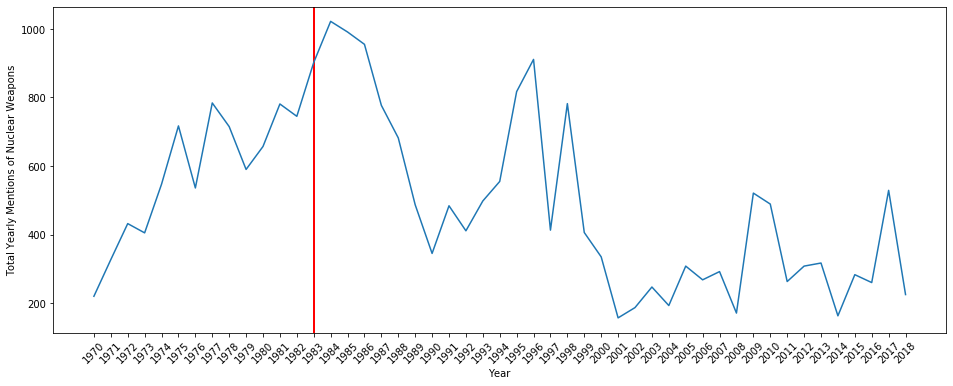

In [46]:
# Visualization of Option 1

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(13,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig1 = sns.lineplot(data=df, x='year', y='nuke_mentions_matcher1', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig1.set(xlabel='Year', ylabel='Total Yearly Mentions of Nuclear Weapons')

[Text(0, 0.5, 'Total Yearly Mentions of Nuclear Weapons'),
 Text(0.5, 0, 'Year')]

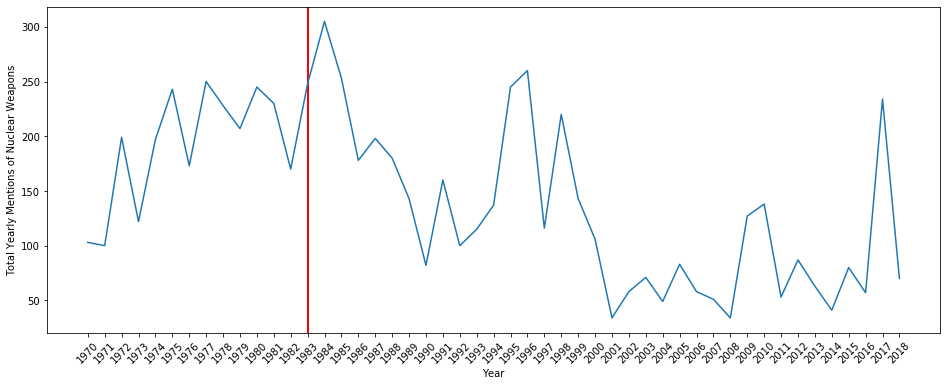

In [47]:
# Visualization of Option 2

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(13,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig1 = sns.lineplot(data=df, x='year', y='nuke_mentions_matcher2', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig1.set(xlabel='Year', ylabel='Total Yearly Mentions of Nuclear Weapons')